# Lab 1
by Domrachev Ivan, B20-RO-01

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Part 1. Loading data from competition

Train dataset

In [2]:
train_data = pd.read_csv('./data/train.csv')
y = train_data['species']
X = train_data.drop(['species', 'id'], axis=1)

train_data.head()

,id,sepal_length,sepal_width,petal_length,petal_width,species
0,0,4.7,3.2,1.6,0.2,Iris-setosa
1,1,6.7,3.0,5.2,2.3,Iris-virginica
2,2,4.4,2.9,1.4,0.2,Iris-setosa
3,3,6.2,3.4,5.4,2.3,Iris-virginica
4,4,5.0,3.0,1.6,0.2,Iris-setosa


## Preprocessing

In [3]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ord_encoder = LabelEncoder()
y_encoded = ord_encoder.fit_transform(y)

# Train/test splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=2)

# Part 2. Model

The model is a simple NN with two hidden layers 50 nodes each, which are activated with a `ReLU` activation. The output layer is activated with `softmax` as a reasonable choice for getting probabilities of belonging to a class as an output. 

In [4]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 10)
        self.layer2 = nn.Linear(10, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x

In [5]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=4, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=3, bias=True)
)

In [6]:
EPOCHS  = 500
X_train_var = Variable(torch.tensor(X_train)).float()
y_train_var = Variable(torch.tensor(y_train)).long()
X_test_var = Variable(torch.tensor(X_test)).float()
y_test_var = Variable(torch.tensor(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in range(EPOCHS):
    y_pred = model(X_train_var)
    loss = loss_fn(y_pred, y_train_var)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test_var)
        correct = (torch.argmax(y_pred, dim=1) == y_test_var).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

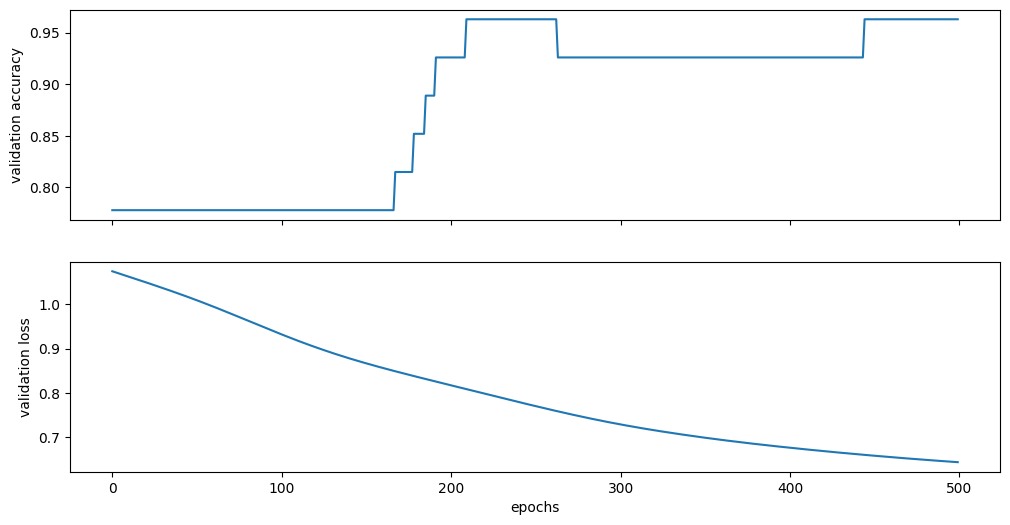

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

# Part 3. Making predictions

In [8]:
test_df = pd.read_csv('./data/test.csv')
X_test = test_df.drop(['id'], axis=1)
test_labels = pd.DataFrame(columns=['species'])
X_test.head()

,sepal_length,sepal_width,petal_length,petal_width
0,6.6,2.9,4.6,1.3
1,6.1,2.6,5.6,1.4
2,6.5,3.0,5.2,2.0
3,5.6,2.5,3.9,1.1
4,7.3,2.9,6.3,1.8


In [9]:
# Scaling
X_test_scaled = scaler.transform(X_test)

In [10]:
X_test_var = Variable(torch.tensor(X_test_scaled)).float()

preds = None
with torch.no_grad():
    preds = model(X_test_var)

test_labels['species'] = ord_encoder.inverse_transform(preds.numpy().argmax(axis=1))

In [11]:
test_labels.reset_index()
test_labels

,species
0,Iris-versicolor
1,Iris-virginica
2,Iris-virginica
3,Iris-versicolor
4,Iris-virginica
5,Iris-setosa
6,Iris-setosa
7,Iris-setosa
8,Iris-virginica
9,Iris-versicolor


In [12]:
test_labels.to_csv('data/answers.csv', index_label='id')